# Understanding mobility during social distancing



As countries around the world work to contain the spread and impact of COVID-19, the World Bank Group is moving quickly to [provide fast, flexible responses](https://www.worldbank.org/en/news/factsheet/2020/02/11/how-the-world-bank-group-is-helping-countries-with-covid-19-coronavirus) to help developing countries strengthen their pandemic response and health care systems.

Part of this response is supporting countries on their decisions to lock-down, and the impact this has, both on the intent to control the spread of disease but also preventing disproportionate socioeconomic impact in most vulnerable communities. As countries monitor and lift lock-downs, the need to understand the degree of mobility and potential hot-spots of disease spread.

### Exploring human mobility data provided by private sector data

As governments across the world implement social distancing policies, it's important to understand how well these policies work to alter human movement patterns and how they impact different communities. 

For example, social distancing may be properly observed in areas where the median income is higher with a more formal workforce. However, areas with more informal work will have a hard time adhering to these guidelines. There are several studies for the USA that confirm this hypothesis. These are just two examples:



| NYT | Reuters |
| :---: | :---: |
| ![](imgs/NYT.png) |![](imgs/Reuters.png)|
| [NYT](https://www.nytimes.com/interactive/2020/04/03/us/coronavirus-stay-home-rich-poor.html) with [Cuebiq](https://www.cuebiq.com/) data: Census track median of intra-day max extent of devices. 10% and 90% wealth percentiles. wealthy counties esentially halted all movement and worked from home, while poorest countries trailed almost a week later, and with significant residual mobility as people could not afford to stay home. |  [Reuters](https://graphics.reuters.com/HEALTH-CORONAVIRUS/USA/qmypmkmwpra/) and MIT. Wealthier counties had less mobility than poorer ones. |



To monitor mobility, there are several publicly available options:
* [Google's publicly available aggregated mobility data](https://www.google.com/covid19/mobility/)
* [Apple's publicly available aggregated mobility data](https://www.apple.com/covid19/mobility)

In Addition, through the World Bank's [Data Partnership](https://datapartnership.org/) the World Bank has access to several other datasets, like 
* [Cuebiq](https://cuebiq.com)
* [Unacast](https://unacast.com)
* [Xmode](https://xmode.io)
* [Veraset](https://Veraset.com)
* [Facebook](https://dataforgood.fb.com/)


In this notebook, we will explore what we can do with each of the public datasets and some of the [Data Partnership](https://datapartnership.org/) ones. However, not every dataset represents every population equally. They may represent people with differing levels of income, or from different regions better.


## Exploring Public Data
Let's start with exploring public mobility data from Apple and Google. We'll focus on India, but this type of analysis should work for any country. 

In [1]:
# Import libraries, and designate where we keep our data folder.
import os
from pathlib import Path
from glob import glob
import pandas as pd

folder=Path("data/mobility")

### Apple mobility data

In [2]:
# Read our downloaded Apple Data
apple_data=[p for p in folder.rglob('apple*.csv')]
apple_mov=pd.read_csv(apple_data[-1])

# Filter to include India
apple_mov=apple_mov[apple_mov['region']=='India']

# Pivot the data so that every date is a row.
apple_mov=apple_mov[apple_mov.columns[3:]].T
rename={56:'A-driving',
        57:'A-walking'}
apple_mov.rename(columns=rename, inplace=True)
apple_mov=apple_mov.iloc[1:]
apple_mov.head()

,A-driving,A-walking
2020-01-13,100,100
2020-01-14,102.35,99.18
2020-01-15,107.96,104.08
2020-01-16,110.77,107.41
2020-01-17,120.64,113.91


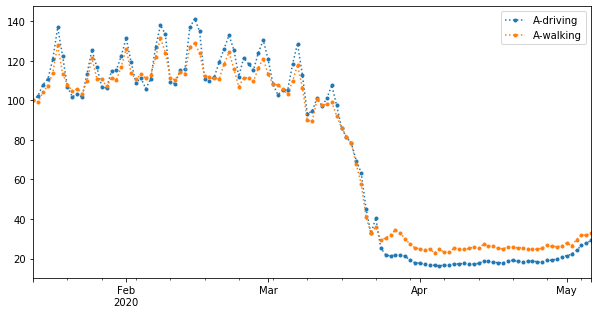

In [3]:
# Set the date as the index, and create a simple plot
apple_mov.index = pd.to_datetime(apple_mov.index,format='%Y-%m-%d')
apple_mov.plot(marker='.', linestyle=':',figsize=(10, 5));

We can see a sharp decline in walking and driving at the end of march / beginning in April.

### Google mobility data

In [4]:
# Read google mobility data
google_data=[p for p in folder.rglob('Global_*.csv')]
google_mov=pd.read_csv(google_data[-1],low_memory=False)

# Filter down to the region
google_mov=google_mov[google_mov['country_region']=='India'] #Only India
google_mov=google_mov[google_mov['sub_region_1'].isnull()]  #Only national series
google_mov=google_mov[google_mov.columns[4:]]
# Rename the columns
rename={'retail_and_recreation_percent_change_from_baseline':'G-retail',
       'grocery_and_pharmacy_percent_change_from_baseline':'G-grocery',
       'parks_percent_change_from_baseline':'G-parks',
       'transit_stations_percent_change_from_baseline':'G-transit',
       'workplaces_percent_change_from_baseline':'G-workplaces',
       'residential_percent_change_from_baseline':'G-residential'}
google_mov.rename(columns=rename, inplace=True)

# Convert date strings into dates, and set the date as index.
google_mov['date']=google_mov['date'].apply(pd.Timestamp)
google_mov = google_mov.set_index('date')
google_mov.head()


,G-retail,G-grocery,G-parks,G-transit,G-workplaces,G-residential
date,,,,,,
2020-02-15,1.0,2.0,3.0,3.0,5.0,0.0
2020-02-16,2.0,2.0,3.0,2.0,0.0,0.0
2020-02-17,-1.0,1.0,3.0,1.0,4.0,0.0
2020-02-18,0.0,2.0,4.0,2.0,3.0,0.0
2020-02-19,0.0,2.0,1.0,1.0,4.0,1.0


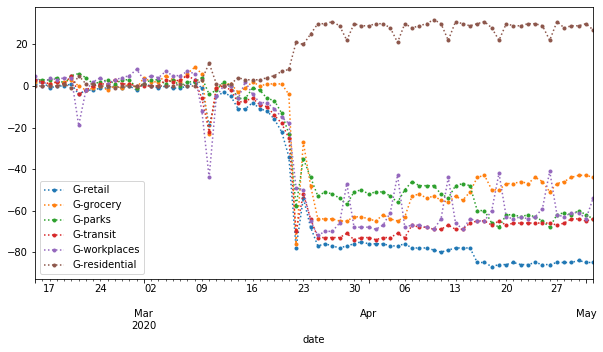

In [5]:
# Show a simple plot
google_mov.plot(marker='.', linestyle=':',figsize=(10, 5));

Note the change after the end of March / Beginning of April.  Residential stayed relatively consistent with a slight uptick.  But we can see a sharp decline in workspaces, and initially in parks.  However, as social distancing measures proceed, park usage seems to crop up again. 

### Comparing Apple and Google Data

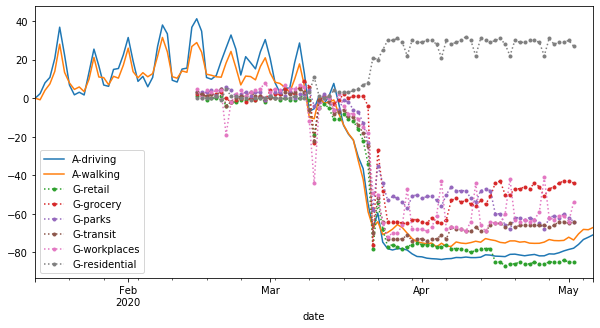

In [6]:
# Create a plot comparing Google and Apple data
ax = (apple_mov-100).plot(figsize=(10, 5))
(google_mov).plot(marker='.',linestyle=':',ax=ax);

This graph gives us a better picture of social distancing activity in India.  As the quarantine starts, there is a drop in transit, but then it begins to creep back up.  Parks usage has been increasing, and grocery has been creeping back up as well.

###  Facebook mobility data

We are going to start with Facebook's new [Movement Range](https://devdatapartnership.herokuapp.com/Facebook.html#Movement-Range-maps) data.

In [7]:
import os
from pathlib import Path

folder=Path("data/mobility")

Since this is still an early release, we get the data on `.csv`s

In [8]:
from glob import glob
fb_data=folder/'FB-mobility'
csvs=[p for p in fb_data.rglob('CSV*/in_gadm*.csv')]
csvs[-1]

PosixPath('data/mobility/FB-mobility/CSVs20200413/in_gadm_mobility_statistics.20200413.csv')

We convert the data into a Pandas DataFrame.

In [9]:
import pandas as pd

rename={'all_day_bing_tiles_visited_relative_change':'r_tiles',
        'all_day_ratio_single_tile_users':'r_tile'}

mov=pd.read_csv(csvs[-1])
mov.rename(columns=rename, inplace=True)
mov['ds']=mov['ds'].apply(pd.Timestamp)
mov = mov.set_index('ds')
mov.head()

,polygon_id,area_type,area_code,polygon_name,country_code,r_tiles,r_tile
ds,,,,,,,
2020-04-08,1132,adm1,IN.TG,Telangana,IN,-0.574119,0.141085
2020-04-08,1113,adm1,IN.JK,Jammu and Kashmir,IN,-0.427373,0.069458
2020-04-12,1132,adm1,IN.TG,Telangana,IN,-0.557866,0.155335
2020-04-12,1110,adm1,IN.GJ,Gujarat,IN,-0.584159,0.107713
2020-04-12,1102,adm1,IN.AR,Arunachal Pradesh,IN,-0.463551,0.055993


There are two kinds of data:
* Mobility Range: The degree of movement, as in the number of map tiles touched by users, relative to a baseline last months.
* Stationary share: The percentage of users always on the same map tile, relative to a baseline last months.


Let's explore first the relation between them on a scatter plot:

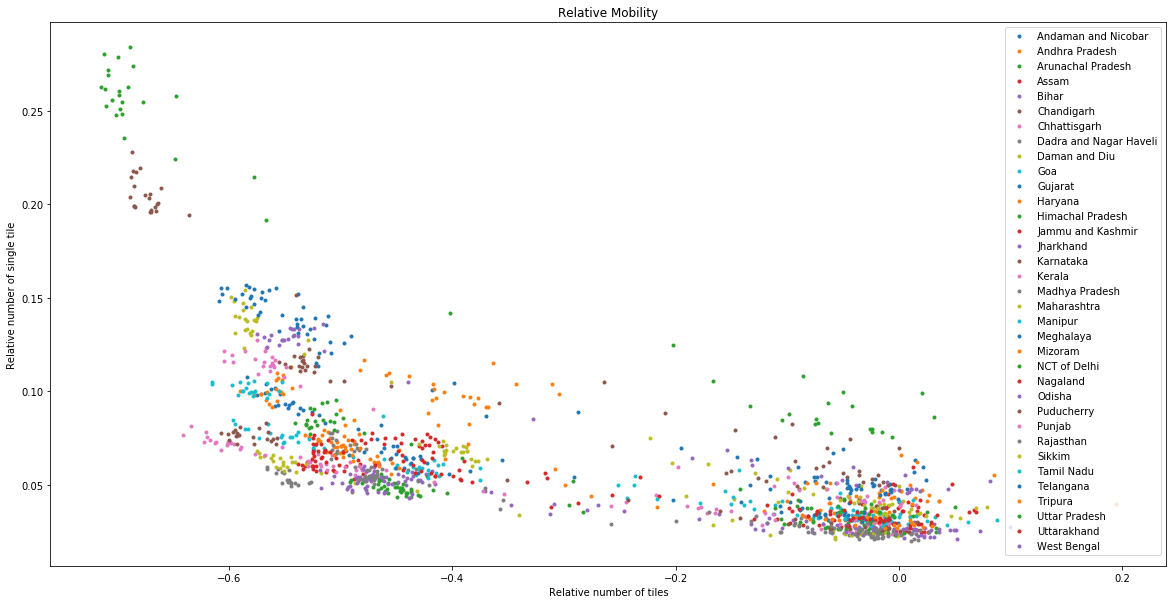

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

groups = mov.groupby('polygon_name')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['r_tiles'], group['r_tile'], marker='.', linestyle='', label=name)
    ax.set_xlabel('Relative number of tiles')
    ax.set_ylabel('Relative number of single tile')
    ax.set_title('Relative Mobility')
ax.legend()

plt.show()

It seems clear, and logical, that there is a proportional relation: The more stationary a region is, the less movement range we see. A higher cluster around `0` (no relative change), means that in these regions, there is more variability of stationary populations.

We also see that some regions tend to be in the same space of the plot, specially the most compliant with the lockdown.

---

#### Mobility range

This data shows the average number of level 16 Bing tiles (0.6km by 0.6km) that a Facebook user (mobile app + location history) was present in during a 24 hour period compared to pre-crisis levels. This is called the Travel Range map.

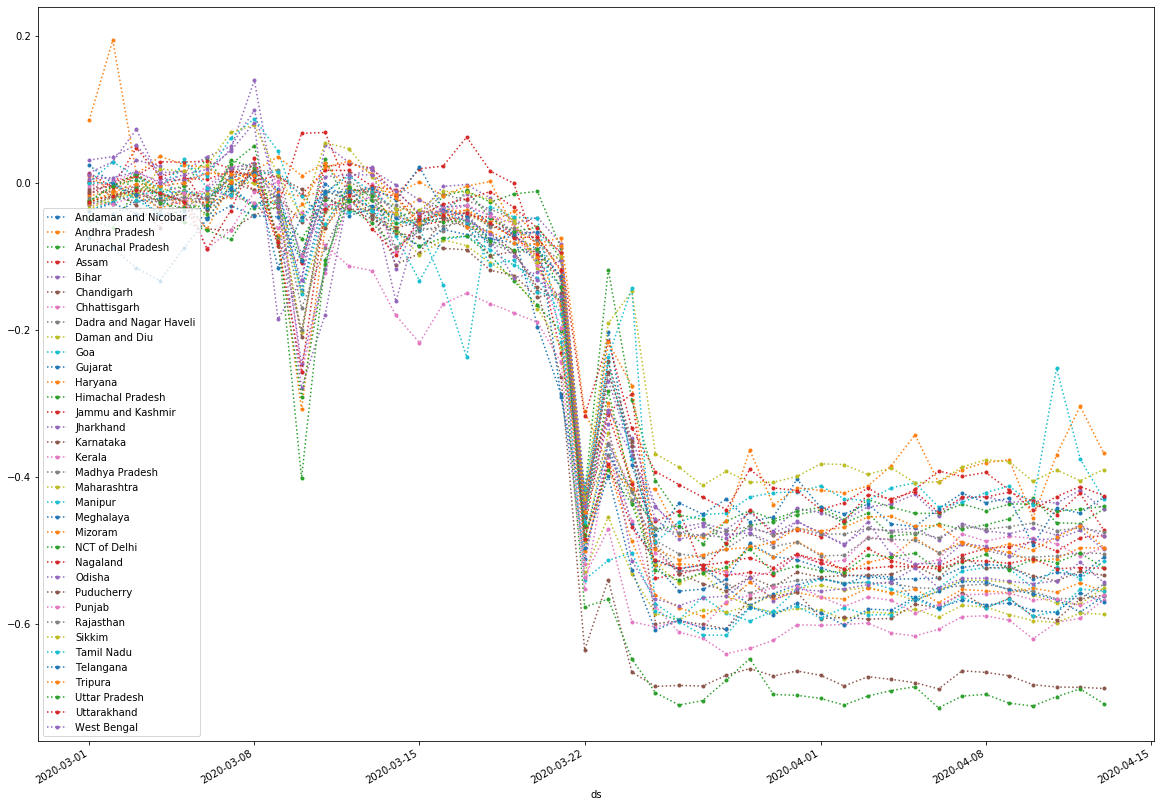

In [11]:
import matplotlib.dates as mdates

ax=mov.groupby('polygon_name')['r_tiles'].plot( marker='.', linestyle=':',figsize=(20, 15));
plt.legend();

ALL regions see a significant decrease in range. The degree of change seems mostly constant, and some places twice than others.

---

#### Stationary share

Percentage of Facebook users (mobile app + location history) that were present in only one such level 16 Bing tile in at least 3 different hours of the day. 

In [12]:
#trick to order by last value
mov.sort_values(by=['r_tile'],ascending=False, inplace=True)

In [13]:
print("The range of value is from %.3f to %.3f"%(mov['r_tile'].min(),mov['r_tile'].max()))

The range of value is from 0.020 to 0.284


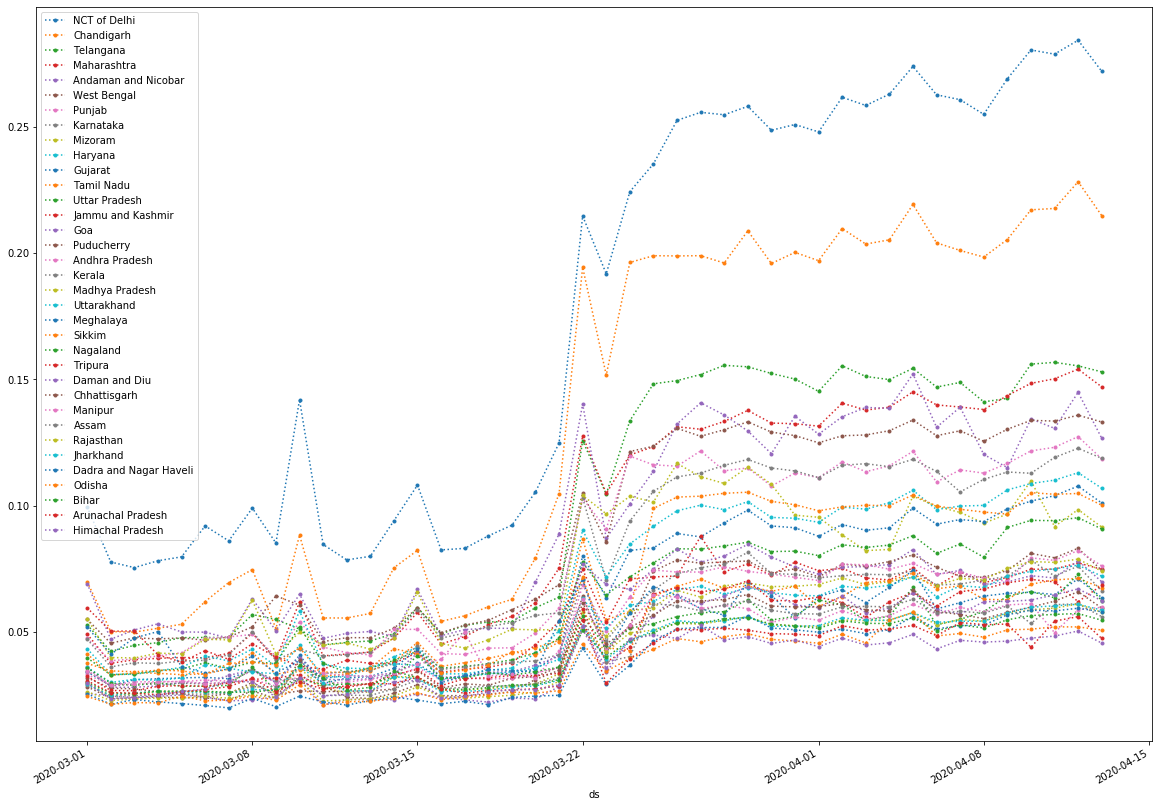

In [14]:
ax=mov.groupby('polygon_name', sort=False)['r_tile'].plot( marker='.', linestyle=':',figsize=(20, 15));
plt.legend()

We see that some regions see little change, while others see `~x15` increase.

---

#### Break up by Indian State

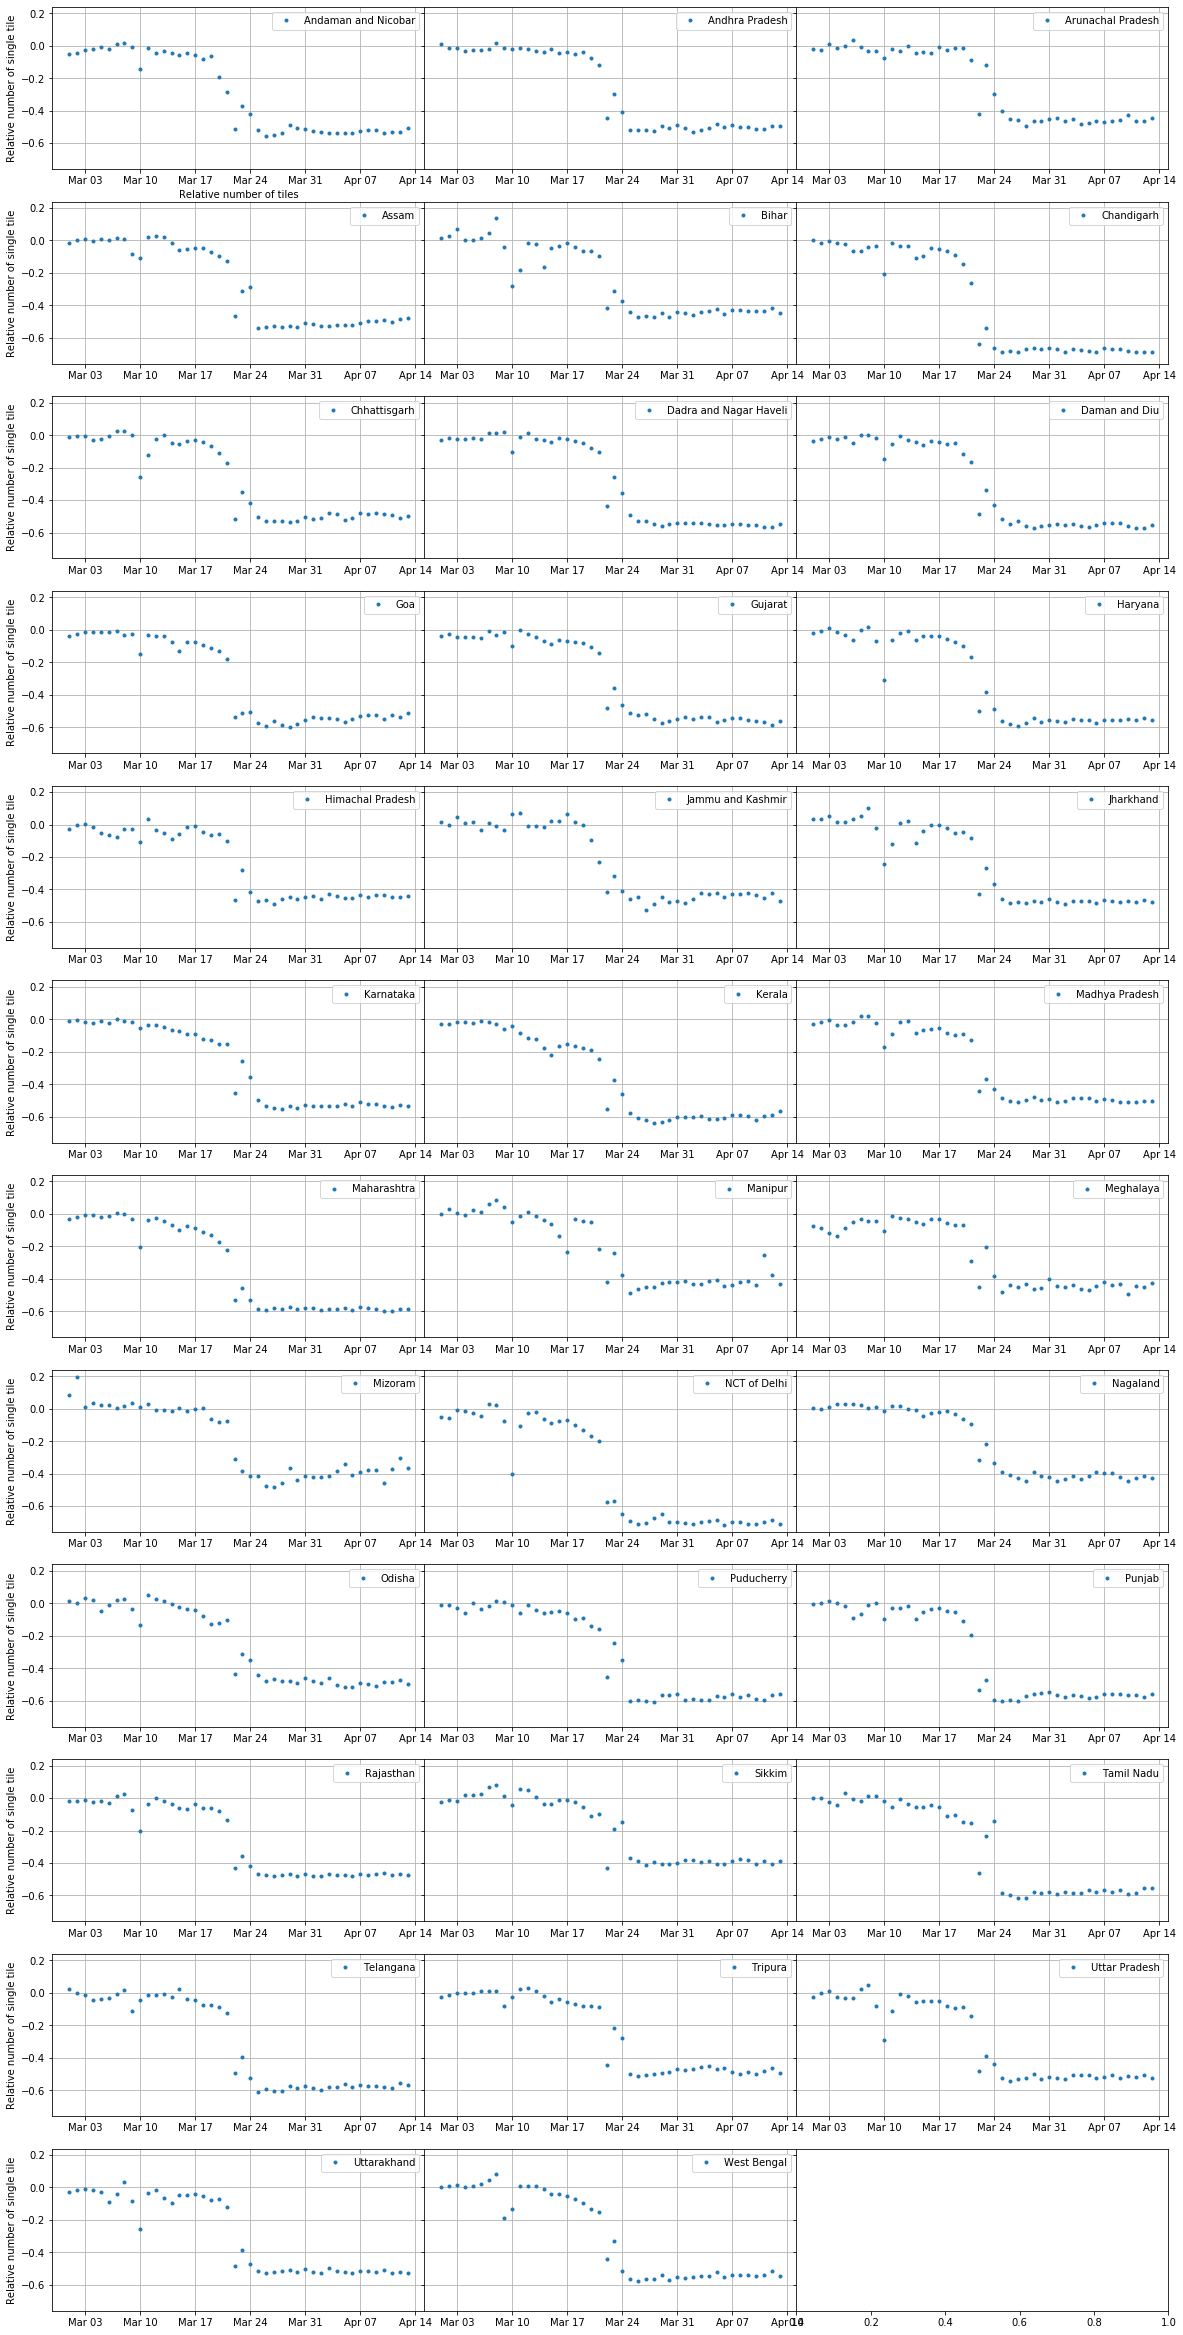

In [15]:
import matplotlib.dates as mdates

groups = mov.groupby('polygon_name')

# Plot
fig, ax = plt.subplots(figsize=(20, 40),nrows=12, ncols=3,sharex=False, sharey=True)
i=0
for name, group in groups:
    row=int(np.floor(i/(ax.shape[1])))
    col=i%(ax.shape[1])
    i=i+1
    #print(i,row,col)
    ax[row,col].plot(group['r_tiles'], marker='.', linestyle='', label=name)
    ax[row,col].margins(0.05)
    ax[0,0].set_xlabel('Relative number of tiles')
    ax[row,0].set_ylabel('Relative number of single tile')
    ax[row,col].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[row,col].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax[row,col].grid(True)
    ax[row,col].legend()

plt.subplots_adjust(left = 0.125,right = 0.9,bottom = 0.1,top = 0.9,wspace = 0,hspace = 0.2)
plt.show()

## Cross comparison between Apple, Google and Facebook

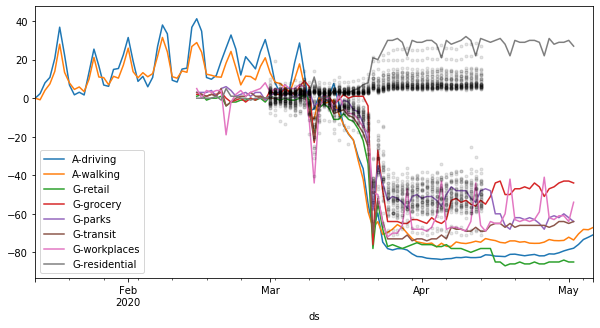

In [16]:
ax = (apple_mov-100).plot(figsize=(10, 5))
(google_mov).plot(ax=ax)
(mov*100).groupby('polygon_name')['r_tile'].plot(ax=ax,marker='.', linestyle='',color='black',alpha=0.1);
(mov*100).groupby('polygon_name')['r_tiles'].plot(ax=ax,marker='.', linestyle='',color='black',alpha=0.1);

## Procesing RAW mobility

What if you have device-level data (e.g. data from `Cuebiq`), but want to aggregate your own metrics, similar to those above?

To do this, we will use real locations of `markets` in Kolkata, India from OSM.  We will simulate device-level data using random points at random times.  

#### Getting the markets
We start off by getting the market location data from OSM using `amenity=marketplace`. We use [overpass-turbo](https://overpass-turbo.eu/s/TO4) We read the file into `geopandas` and get the centroids of those markets.

In [17]:
import pyproj
pyproj.Proj("+init=epsg:4326")

pyproj.Proj('+units=m +init=epsg:4326', preserve_units=True)

There are 31 markets in the area


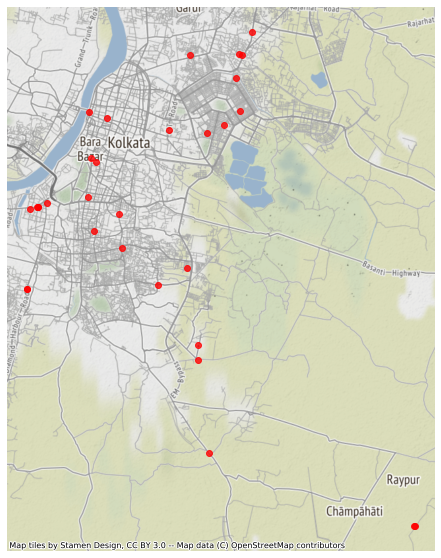

In [18]:
# Get locations of real amenity=marketplace from OSM
import geopandas as gpd
import contextily as ctx
marketplace_file=folder/'Kolkata-marketplace.geojson'

# Read the geojson file and convert it to EGPS3857
markets = gpd.read_file(marketplace_file).to_crs({'init': 'epsg:3857'})

# Convert the geometry to centroids as opposed to polygons. 
markets['geometry'] = markets['geometry'].centroid

# Create a simple plot of the markets
ax = markets.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)
ax.set_axis_off()
print("There are %i markets in the area"%len(markets))

#### Creating a market buffer
We add a buffer of 500m around them so we assign any device-level ping as a visit to the market.

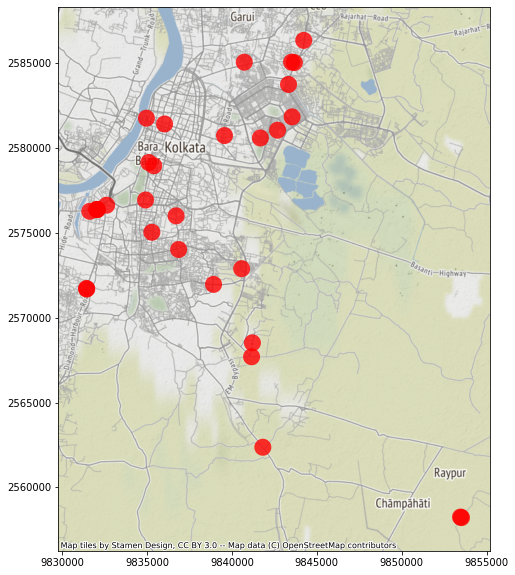

In [19]:
# Add a 500m buffer
markets_zones=markets
markets_zones.geometry=markets.geometry.buffer(500)

# Make a simple plot
ax = markets.plot(figsize=(10, 10), alpha=0.8,color='red')
ctx.add_basemap(ax)

#### Creating simulated dates
In order to created simulated data, we need some code to generated simulated dates.  Here we have some code that will generate a random date between a provided interval.

In [20]:

import random
import time

def strTimeProp(start, end, format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formated in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def randomDate(start, end, prop):
    return strTimeProp(start, end, '%d/%m/%Y %I:%M %p', prop)

#randomDate("1/1/2008 1:30 PM", "1/1/2009 4:50 AM", random.random())

#### Create random pings at random times
No we are ready to generate synthetic data.  We will generate random pings at random times.  These pings will be limited by a bounding box of all the markets, but each ping does necessarily have to fall into a market.

In [21]:
#create synthtetic data
import numpy as np
from shapely.geometry import Point

xmin, ymin, xmax,  ymax = markets.total_bounds
num_points = 200000
xc = (xmax - xmin) * np.random.random(num_points) + xmin
yc = (ymax - ymin) * np.random.random(num_points) + ymin
tc = [randomDate("4/1/2020 1:01 AM", "20/4/2020 04:50 AM", random.random()) for i in np.empty(num_points)]
points_geom = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
points = gpd.GeoDataFrame(pd.DataFrame({'time':tc}),geometry=points_geom, crs=markets.crs)
points.crs = markets.crs
points.head()

,time,geometry
0,28/02/2020 07:45 PM,POINT (9845269.370 2585592.069)
1,21/02/2020 07:41 PM,POINT (9838860.837 2568362.007)
2,09/02/2020 12:34 PM,POINT (9835194.903 2584734.155)
3,16/01/2020 01:25 AM,POINT (9834310.364 2586797.338)
4,06/03/2020 03:27 AM,POINT (9833397.813 2583220.593)


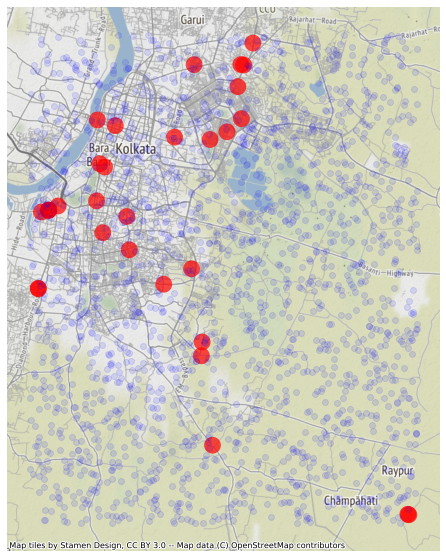

In [22]:
# Create a simple plot of the markets.
ax =  markets.plot(figsize=(10, 10), alpha=.7,color='red')
points.sample(n=int(num_points/100)).plot(ax=ax, alpha=0.1,color='blue')

ctx.add_basemap(ax)
ax.set_axis_off()

#### Determine which pings are within a market boundary.
With a Spatial join, we can  filter out any point not intersecting our buffered marketplaces.

In [23]:
inside=gpd.sjoin(points, markets, how='left',)
inside=inside[inside.notnull()['id']]
inside.head()

,time,geometry,index_right,id,@id,amenity,building,name,operator,type,...,addr:postcode,addr:street,leisure,alt_name,alt_name:short,name:en,short_name,opening_hours,designation,description
9,14/03/2020 03:59 AM,POINT (9853293.100 2558184.783),20.0,way/486526195,way/486526195,marketplace,yes,RABI MARKET,None,None,...,743363,Piali-Champahati Road,None,None,None,None,None,None,None,None
9,14/03/2020 03:59 AM,POINT (9853293.100 2558184.783),26.0,node/4803445395,node/4803445395,marketplace,None,Nanda Market,None,None,...,743363,BIPIN CHANDRA PAL ROAD,None,None,None,None,None,None,None,None
54,12/03/2020 04:23 PM,POINT (9835677.097 2581118.422),28.0,node/6173706994,node/6173706994,marketplace,None,None,None,None,...,None,None,None,None,None,None,None,None,None,fruit market
116,22/01/2020 02:31 PM,POINT (9831650.417 2576555.681),2.0,relation/9907940,relation/9907940,marketplace,None,None,None,multipolygon,...,None,None,None,None,None,None,None,None,None,None
116,22/01/2020 02:31 PM,POINT (9831650.417 2576555.681),4.0,way/142718051,way/142718051,marketplace,commercial,Babu Bazar,None,None,...,700023,Bhukaliash Road,None,None,None,None,None,None,None,None


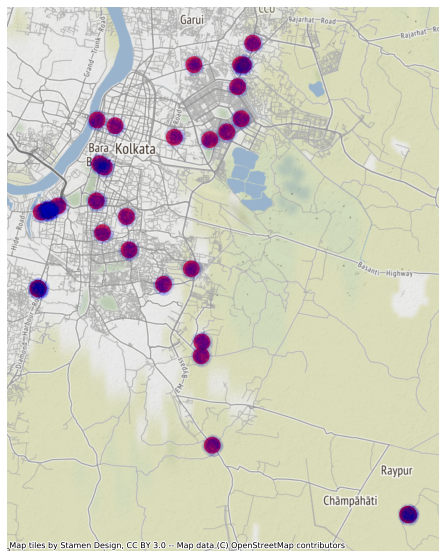

In [24]:
# Create a plot of the points that are inside markets.
ax =  markets.plot(figsize=(10, 10), alpha=.7,color='red')
inside.plot(ax=ax, alpha=0.01,color='blue')

ctx.add_basemap(ax)
ax.set_axis_off()

#### Date-Binning of Supermarket Mobility
Now, we need to bin the market mobility by date:

In [25]:
# Make the date string into a datetime 
inside['time'] = pd.to_datetime(inside['time'], format='%d/%m/%Y %I:%M %p')

# Create a day column
inside['day'] = pd.to_datetime(inside['time'], format='%d/%m/%Y').dt.strftime('%m/%d/%Y')
inside.head()

,time,geometry,index_right,id,@id,amenity,building,name,operator,type,...,addr:street,leisure,alt_name,alt_name:short,name:en,short_name,opening_hours,designation,description,day
9,2020-03-14 03:59:00,POINT (9853293.100 2558184.783),20.0,way/486526195,way/486526195,marketplace,yes,RABI MARKET,None,None,...,Piali-Champahati Road,None,None,None,None,None,None,None,None,03/14/2020
9,2020-03-14 03:59:00,POINT (9853293.100 2558184.783),26.0,node/4803445395,node/4803445395,marketplace,None,Nanda Market,None,None,...,BIPIN CHANDRA PAL ROAD,None,None,None,None,None,None,None,None,03/14/2020
54,2020-03-12 16:23:00,POINT (9835677.097 2581118.422),28.0,node/6173706994,node/6173706994,marketplace,None,None,None,None,...,None,None,None,None,None,None,None,None,fruit market,03/12/2020
116,2020-01-22 14:31:00,POINT (9831650.417 2576555.681),2.0,relation/9907940,relation/9907940,marketplace,None,None,None,multipolygon,...,None,None,None,None,None,None,None,None,None,01/22/2020
116,2020-01-22 14:31:00,POINT (9831650.417 2576555.681),4.0,way/142718051,way/142718051,marketplace,commercial,Babu Bazar,None,None,...,Bhukaliash Road,None,None,None,None,None,None,None,None,01/22/2020


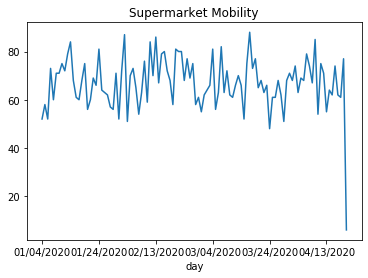

In [26]:
# Create a simple plot showing market mobility in India!
ax = inside.groupby('day').count()['time'].plot()
ax.set_title('Supermarket Mobility');

If you have device level data, such as that provided by the Data Partners in the Data Partnership, you can do this for any type of location in any place of the world.  Being able to measure mobility this way is a powerful tool for analyzing the impacts of social distancing, and adjusting policies to help prevent the spread of Covid19.

## Review
In this post, you learned how to work with Apple, Google and Facebook data.  You learned how to simulate your own device-level data, and how to use your simulated data to calculate movement and attendance in different types of places, anywhere in the world.  

If you are a Development Partner, and would like to use Data Partnership data, submit a project!

If you are a Data Provider and want to see your data be used for world-changing impact, sign up to work with the Data Partnership!